In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch.utils.data import RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Compose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomGamma
)

from utils.metrics import dice
from utils.data import NeuronSegmDataset

from torch import nn
import torch

from utils.encoders import ResNetEncoders
from unet.unet import UNet

def tonp(t):
    return t.detach().cpu().numpy()
    
def process_batch(b):
    X, y  = b
    X = X.to(DEVICE)
    y = torch.tensor(y, dtype=torch.float).to(DEVICE)
    return X, y

def prediction_to_numpy(pred):
    return pred.sigmoid().detach().cpu().numpy() 

def evaluate(model, loader, threshold):
    model = model.eval()
    for b in loader:
        X, y = process_batch(b)
        res = model(X)
    val_loss = nn.BCEWithLogitsLoss()(res, y)
    pred_Y, real_Y = prediction_to_numpy(res) > threshold, tonp(y)> threshold
    dices = []
    for ypred, yreal in zip(pred_Y, real_Y):
        dices.append(dice(ypred, yreal))
    return np.array(dices).mean(), val_loss.detach().cpu().numpy()




### Create a Fully Connected Segmentation Architecture 
This means it will work similary to any other CONV architecture, in the end it will map the dense layer into a 1,192,192 shape

In [21]:

class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 tensor
        # Assume input shape to be (bs, 1, 192, 192)
        

        
    def forward(self, x):
        after_conv = ??? 
        flatten = after_conv.view(after_conv.shape[0], -1)

        lin = self.linear(flatten)
        
    
        return lin.view(x.shape[0],1,192,192)
        

Writing .solutions/ssn.py


### Create a Unet-Like architecture this means a network that will have the pooling path, upsampling and lateral connections.

![alt text](https://cdn-images-1.medium.com/max/1600/1*O2NbipwBOdTMtj7ThBNTPQ.png)

In [2]:

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()

        
        self.layer0 = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, padding=1))
        
        

        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 =  # similar to layer1 create layer 2 doubling the amount of filters
        
        self.layer3 =  # similar to layer2 create layer 2 doubling the amount of filters
        
        self.layer4 =  # similar to layer3 create layer 2 doubling the amount of filters
        
        
        self.upsample = # create and Upsample layer (factor=2)
        
        # Upstream layers cant use pooling operations and their sizes need to correpsond with the concatanated output map
        
        self.layer1_up_stream = nn.Sequential(nn.Conv2d(??, ??, kernel_size=1), nn.ReLU())  
        self.layer2_up_stream = nn.Sequential(nn.Conv2d(??, ??, kernel_size=1), nn.ReLU())
        self.layer3_up_stream = nn.Sequential(nn.Conv2d(??, ??, kernel_size=1), nn.ReLU())
        self.layer4_up_stream = nn.Sequential(nn.Conv2d(??, 1, kernel_size=1), nn.ReLU())

        

        
    def forward(self, x):
        down0 = self.layer0(x)
        down1 = self.layer1(down0)
        down2 = self.layer2(down1)
        down3 = self.layer3(down2)
        down4 = self.layer4(down3)
        
        up1 = self.upsample(down4)
        
        
    
        # now you need to concatanate the  up1 with down3
        # ??
        
        # now you need to concatanate the  up2 with down2
        # ??
        
        # now you need to concatanate the  up3 with down1
        # ??
        # now you need to concatanate the  up4 with original X
        x = self.layer4_up_stream(torch.cat([x, up4], dim=1))
        
        
        return x
                


SyntaxError: invalid syntax (<ipython-input-2-4066afd1a9e7>, line 17)

In [104]:
neuron_target = './data/train-labels.tif'
neuron_train = './data/train-volume.tif'


trans_train = transforms.Compose([transforms.Resize(192), 
                                  transforms.ToTensor()])
trans_test = transforms.Compose([transforms.Resize(192), 
                                 transforms.ToTensor()])

aug = Compose([
#     RandomGamma(), 
#                VerticalFlip(), 
#                HorizontalFlip(),
#                RandomRotate90(), 
#                GridDistortion(),
#                ElasticTransform(),
#                OpticalDistortion(distort_limit=1, shift_limit=1)
])


train_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train, augmenter=aug)
test_ds = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_test)
train_ds_val = NeuronSegmDataset(neuron_train, neuron_target, image_transform=trans_train)


random_training_sampler = RandomSampler(train_ds)
train_idx , test_idx = train_test_split(range(len(train_ds)), test_size=0.15)

random_sampler_train = RandomSampler(train_idx)
sampler_test = SequentialSampler(test_idx)

training_data_loader = DataLoader(train_ds, batch_size=1, num_workers=1, sampler=random_training_sampler)
test_data_loader = DataLoader(test_ds, batch_size=6, num_workers=1, sampler=sampler_test)
train_ds_val_loader = DataLoader(train_ds_val, batch_size=6, num_workers=1, sampler=random_training_sampler)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SSN().to(DEVICE)
model = AlaUnet().to(DEVICE)

optim = torch.optim.Adam(model.parameters())
epochs = 1000
loss_bce = nn.BCEWithLogitsLoss()
loss = 0
THRESHOLD = 0.5
history = defaultdict(list)

/home/i008/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch 0
dice 0.8967653864760669
loss 0.43570846
train_dice 0.9061769816879344
train_loss 0.42968106
epoch 1
dice 0.8706980192322428
loss 0.4576565
train_dice 0.8766741156233747
train_loss 0.45325544
epoch 2
dice 0.8933281565210794
loss 0.39248186
train_dice 0.9009295753089518
train_loss 0.37948376
epoch 3
dice 0.8731689493631712
loss 0.49062502
train_dice 0.8824052823651577
train_loss 0.491057
epoch 4
dice 0.8862001728059287
loss 0.41528028
train_dice 0.8953353630809199
train_loss 0.39870617
epoch 5
dice 0.8656350818243844
loss 0.58509415
train_dice 0.874547071847699
train_loss 0.59115994
epoch 6
dice 0.8998189054881509
loss 0.38907167
train_dice 0.9132614857726081
train_loss 0.34842202
epoch 7
dice 0.8935237354769837
loss 0.39502928
train_dice 0.8984856089450228
train_loss 0.38116276
epoch 8
dice 0.8928602213394777
loss 0.3861071
train_dice 0.8985276705108811
train_loss 0.37558806
epoch 9
dice 0.8965981081372119
loss 0.3987445
train_dice 0.9143405829238023
train_loss 0.35832423
epoch 

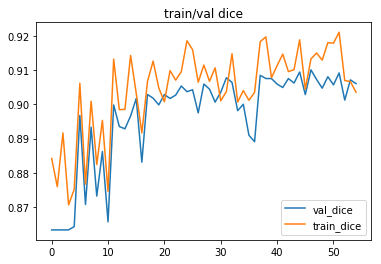

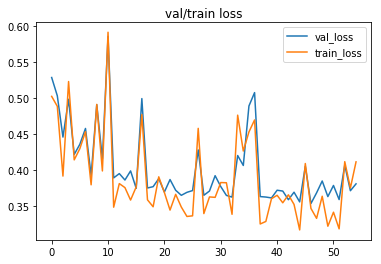

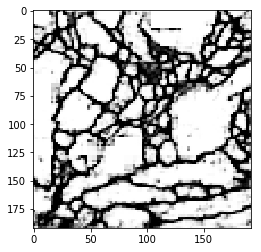

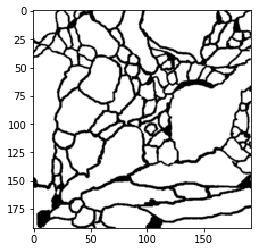

In [107]:
epochs=5

for i, _ in enumerate(range(epochs)):
    for batch in training_data_loader:
        X, y = process_batch(batch)
        prediction = model(X)  # [N, 2, H, W]
        loss = loss_bce(prediction, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()   
        
    val_mean_dice, val_loss = evaluate(model, test_data_loader, threshold=THRESHOLD)
    train_mean_dice, train_loss = evaluate(model, train_ds_val_loader, threshold=THRESHOLD)
    
    print("epoch", i)
    print('dice', val_mean_dice)
    print('loss', val_loss)
    print('train_dice', train_mean_dice)
    print('train_loss', train_loss)
    model.train()
    
    history['val_dice'].append(val_mean_dice)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_mean_dice)
    history['train_loss'].append(train_loss)
    
    

df = pd.DataFrame(history)

plt.figure()
plt.title('train/val dice')
plt.plot(df.val_dice)
plt.plot(df.train_dice)
plt.legend(['val_dice', 'train_dice'])
plt.figure()
plt.title('val/train loss')
plt.plot(df.val_loss)
plt.plot(df.train_loss)
plt.legend(['val_loss', 'train_loss'])


plt.figure()
plt.imshow(prediction[0][0].detach().sigmoid().cpu().numpy(), cmap='gray')
plt.figure()
plt.imshow(y.detach()[0][0].cpu().numpy(), cmap='gray')


In [5]:
# %load .solutions/ssn.py

class SSN(nn.Module):
    def __init__(self):
        super(SSN, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.linear = nn.Linear(1 * 12 * 12, 36864)

        
    def forward(self, x):
        after_conv =self.layer4(self.layer3(self.layer2(self.layer1(x))))
        flatten = after_conv.view(after_conv.shape[0], -1)

        lin = self.linear(flatten)
        
    
        return lin.view(x.shape[0],1,192,192)
        

In [101]:
M = torch.rand(32, 24, 64, 64) # => (32, 24*64 *64)

M.view(M.shape[0], -1).shape
24*64*64

98304

In [103]:
# %load .solutions/alaunet.py

class AlaUnet(nn.Module):
    def __init__(self):
        super(AlaUnet, self).__init__()

        
        # Create 4 conv layers with 16, 32, 64, 16 inputs
        # Create a Linear layer that will map this into a 192x192 vector
        # Assume input shape to be (1, 1, 192, 192)
        
        
        self.layer0 = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, padding=1))
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.upsample = nn.Upsample(scale_factor=2)
        
        self.layer1_up_stream = nn.Sequential(nn.Conv2d(48, 16, kernel_size=1), nn.ReLU())  
        self.layer2_up_stream = nn.Sequential(nn.Conv2d(24, 20, kernel_size=1), nn.ReLU())
        self.layer3_up_stream = nn.Sequential(nn.Conv2d(24, 16, kernel_size=1), nn.ReLU())
        self.layer4_up_stream = nn.Sequential(nn.Conv2d(17, 1, kernel_size=1), nn.ReLU())

    def forward(self, x):
        down0 = self.layer0(x)
        down1 = self.layer1(down0)
        down2 = self.layer2(down1)
        down3 = self.layer3(down2)
        down4 = self.layer4(down3)
        
        up1 = self.upsample(down4)
        
        first_up = torch.cat([up1, down3], dim=1)
        up2 = self.upsample(self.layer1_up_stream(first_up))
        
        second_up = torch.cat([up2, down2], dim=1)
        up3 = self.upsample(self.layer2_up_stream(second_up))
        
        third_up = torch.cat([up3, down1],dim=1)
        up4 = self.upsample(self.layer3_up_stream(third_up))

        x = self.layer4_up_stream(torch.cat([x, up4], dim=1))
        return x
                

In [96]:
up = nn.ConvTranspose2d(1, 1, kernel_size=2,
                                         stride=2)

# up.weight = torch.ptorch.ones(1,1,2,2)
# 

import torch.nn.functional as F
x = torch.from_numpy(np.array([[[[1,2],[3,4]]]])).float()
F.conv_transpose2d(x, torch.ones(1,1,2,2), stride=2)

tensor([[[[1., 1., 2., 2.],
          [1., 1., 2., 2.],
          [3., 3., 4., 4.],
          [3., 3., 4., 4.]]]])

In [74]:
up.weight.shape

torch.Size([1, 1, 2, 2])

In [79]:
x = torch.rand(1,1,2,2)

x = torch.from_numpy(np.array([[[[1,2],[3,4]]]])).float()

tensor([[[[ 0.6910,  0.0640,  0.9132, -0.3407],
          [-0.0157, -0.0302, -0.5002, -0.5292],
          [ 1.1354, -0.7454,  1.3577, -1.1501],
          [-0.9847, -1.0282, -1.4691, -1.5272]]]],
       grad_fn=<ThnnConvTranspose2DBackward>)

In [23]:
list(up.parameters())[0].shape

torch.Size([32, 32, 2, 2])

In [48]:
nn.ConvTranspose2d?

In [108]:
y

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.0353, 0.0157, 0.1412],
          [1.0000, 1.0000, 1.0000,  ..., 0.1922, 0.5020, 0.8353],
          [1.0000, 1.0000, 1.0000,  ..., 0.9098, 0.9882, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]]],
       device='cuda:0')

In [110]:
prediction.sigmoid()

tensor([[[[0.9999, 0.9999, 0.9996,  ..., 0.6815, 0.9000, 0.9024],
          [0.9999, 0.9999, 0.9996,  ..., 0.6836, 0.9114, 0.9153],
          [0.9989, 0.9988, 0.9977,  ..., 0.9044, 0.9620, 0.9582],
          ...,
          [0.5715, 0.5684, 0.7354,  ..., 0.7157, 0.8690, 0.8713],
          [0.8738, 0.8779, 0.9452,  ..., 0.9779, 0.9693, 0.9676],
          [0.8669, 0.8730, 0.9463,  ..., 0.9773, 0.9696, 0.9670]]]],
       device='cuda:0', grad_fn=<SigmoidBackward>)